# Load library

In [1]:
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

# Load data

In [3]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [4]:
train_df.shape, test_df.shape

((200000, 202), (200000, 201))

In [5]:
train_df.head(1)

ID_code  target   var_0   var_1    var_2  var_3    var_4   var_5   var_6  \
0  train_0       0  8.9255 -6.7863  11.9081  5.093  11.4607 -9.2834  5.1187   

     var_7  ...  var_190  var_191  var_192  var_193  var_194  var_195  \
0  18.6266  ...   4.4354   3.9642   3.1364    1.691  18.5227  -2.3978   

   var_196  var_197  var_198  var_199  
0   7.8784   8.5635  12.7803  -1.0914  

[1 rows x 202 columns]

In [6]:
test_df.head(1)

ID_code    var_0   var_1    var_2   var_3    var_4   var_5   var_6    var_7  \
0  test_0  11.0656  7.7798  12.9536  9.4292  11.4327 -2.3805  5.8493  18.2675   

    var_8  ...  var_190  var_191  var_192  var_193  var_194  var_195  var_196  \
0  2.1337  ...  -2.1556  11.8495    -1.43   2.4508  13.7112   2.4669   4.3654   

   var_197  var_198  var_199  
0    10.72  15.4722  -8.7197  

[1 rows x 201 columns]

## check missing data

In [7]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [12]:
missing_data(train_df).T.sort_values('Total', ascending=False)

Total Percent    Types
ID_code     0     0.0   object
var_136     0     0.0  float64
var_126     0     0.0  float64
var_127     0     0.0  float64
var_128     0     0.0  float64
...       ...     ...      ...
var_68      0     0.0  float64
var_69      0     0.0  float64
var_70      0     0.0  float64
var_71      0     0.0  float64
var_199     0     0.0  float64

[202 rows x 3 columns]

In [13]:
missing_data(test_df).T.sort_values('Total', ascending=False)

Total Percent    Types
ID_code     0     0.0   object
var_137     0     0.0  float64
var_127     0     0.0  float64
var_128     0     0.0  float64
var_129     0     0.0  float64
...       ...     ...      ...
var_69      0     0.0  float64
var_70      0     0.0  float64
var_71      0     0.0  float64
var_72      0     0.0  float64
var_199     0     0.0  float64

[201 rows x 3 columns]

# Data Profiling

## describe

In [15]:
train_df.describe().T.sort_values('mean')

count       mean        std      min        25%       50%  \
var_90   200000.0 -16.548147  13.152810 -61.7180 -26.665600 -16.48260   
var_45   200000.0 -12.699667  21.404912 -90.2525 -28.730700 -12.54720   
var_47   200000.0 -12.471737  10.579862 -47.6862 -20.654525 -12.48240   
var_61   200000.0 -11.946744  11.622948 -48.8027 -20.901725 -11.89200   
var_187  200000.0 -10.335043  11.574708 -47.7536 -19.205125 -10.20975   
...           ...        ...        ...      ...        ...       ...   
var_102  200000.0  22.294908   8.628179  -7.3829  16.047975  22.30685   
var_136  200000.0  22.968602  10.382235  -9.9493  14.933900  22.94830   
var_160  200000.0  24.259300  10.880263  -7.4522  15.696125  23.86450   
var_70   200000.0  24.446811  11.951742 -17.0275  15.256625  24.44500   
var_120  200000.0  24.521078  12.121016 -18.6962  15.696275  24.35470   

               75%      max  
var_90   -6.409375  27.2713  
var_45    3.150525  62.0844  
var_47   -4.244525  20.6854  
var_61   -3.225450  27.1029  
var_187  -1.466000  22.7861  
...            ...      ...  
var_102  28.682225  51.3265  
var_136  31.042425  54.5794  
var_160  32.622850  58.3942  
var_70   33.633150  64.4644  
var_120  33.105275  74.0321  

[201 rows x 8 columns]

In [16]:
test_df.describe().T.sort_values('mean')

count       mean        std      min        25%       50%  \
var_90   200000.0 -16.334976  13.174833 -57.3853 -26.461300 -16.18835   
var_45   200000.0 -12.666095  21.402708 -83.6921 -28.673200 -12.57780   
var_47   200000.0 -12.455577  10.535003 -46.5542 -20.591000 -12.43880   
var_61   200000.0 -11.956023  11.632700 -48.3369 -20.948500 -11.95720   
var_187  200000.0 -10.291919  11.562352 -47.3064 -19.136225 -10.16680   
...           ...        ...        ...      ...        ...       ...   
var_102  200000.0  22.334372   8.630791  -7.9256  16.129275  22.30400   
var_136  200000.0  23.019125  10.373414  -9.7535  14.972100  22.97520   
var_160  200000.0  24.146181  10.876184  -8.9257  15.567800  23.73440   
var_70   200000.0  24.442541  11.933799 -17.0275  15.328700  24.42690   
var_120  200000.0  24.536099  12.105735 -19.5415  15.761400  24.36650   

               75%      max  
var_90   -6.207550  22.3375  
var_45    3.094500  58.3078  
var_47   -4.304400  20.4969  
var_61   -3.228375  26.3994  
var_187  -1.438800  23.5699  
...            ...      ...  
var_102  28.720150  51.9845  
var_136  31.068500  54.0145  
var_160  32.495275  64.2911  
var_70   33.598525  63.9827  
var_120  33.061100  68.4661  

[200 rows x 8 columns]

## train vs test

In [17]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

<Figure size 432x288 with 0 Axes>

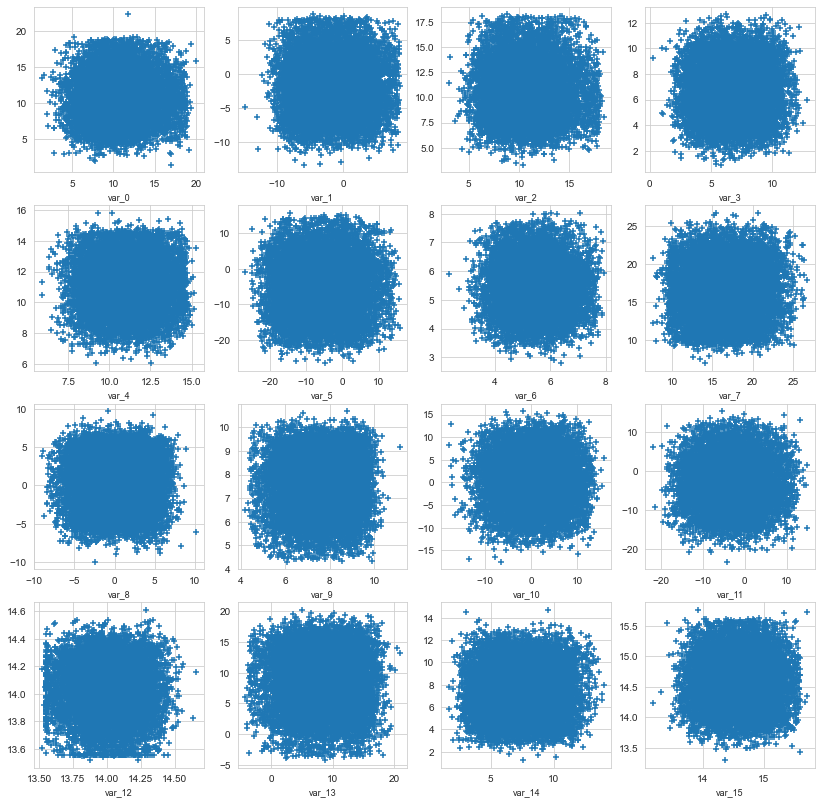

In [19]:
features = ['var_0', 'var_1','var_2','var_3', 'var_4', 'var_5', 'var_6', 'var_7', 
           'var_8', 'var_9', 'var_10','var_11','var_12', 'var_13', 'var_14', 'var_15', 
           ]
plot_feature_scatter(train_df.sample(frac=0.05),test_df.sample(frac=0.05), features)

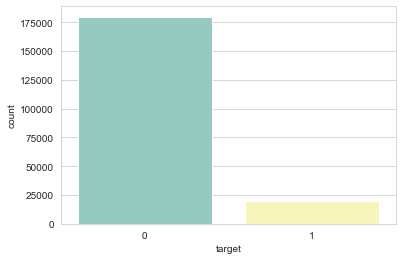

In [20]:
sns.countplot(train_df['target'], palette='Set3')

In [21]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 10.049% target values with 1


## Density plots of features
* We represent with different colors the distribution for values with target value 0 and 1.
* 즉, 피쳐별로, 타겟이 0일때와 1일때의 값 분포가 비슷한지, 다른게 있는지 살펴본다
* 분포가 다르면, (변별력이 있는) 좋은 피쳐
* 나중에, 모델의 피쳐 중요도 차트와 같이 살펴보자

In [22]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

<Figure size 432x288 with 0 Axes>

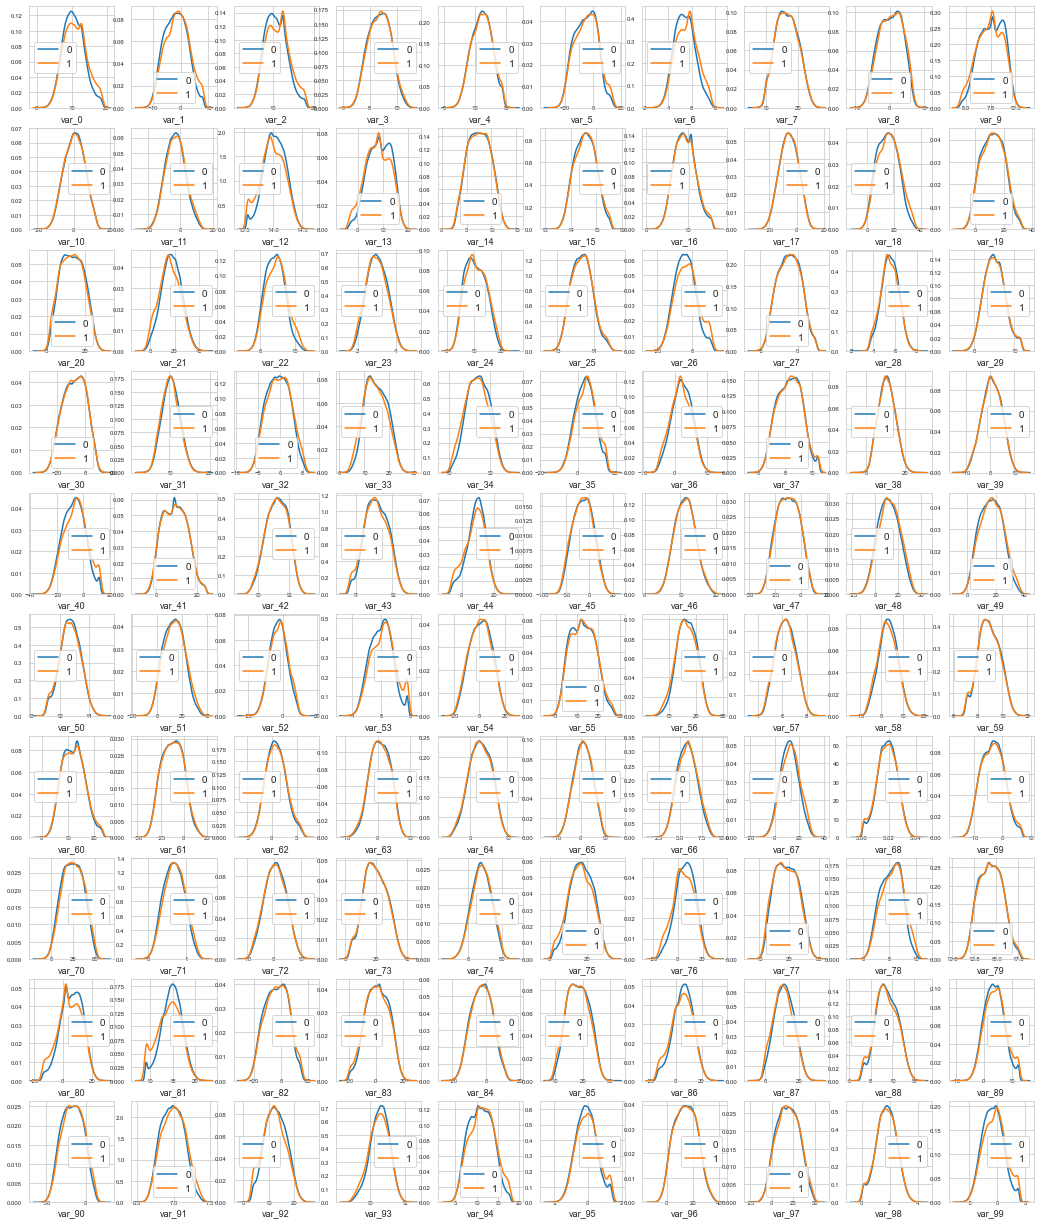

In [23]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
features = train_df.columns.values[2:102]
plot_feature_distribution(t0, t1, '0', '1', features)

<Figure size 432x288 with 0 Axes>

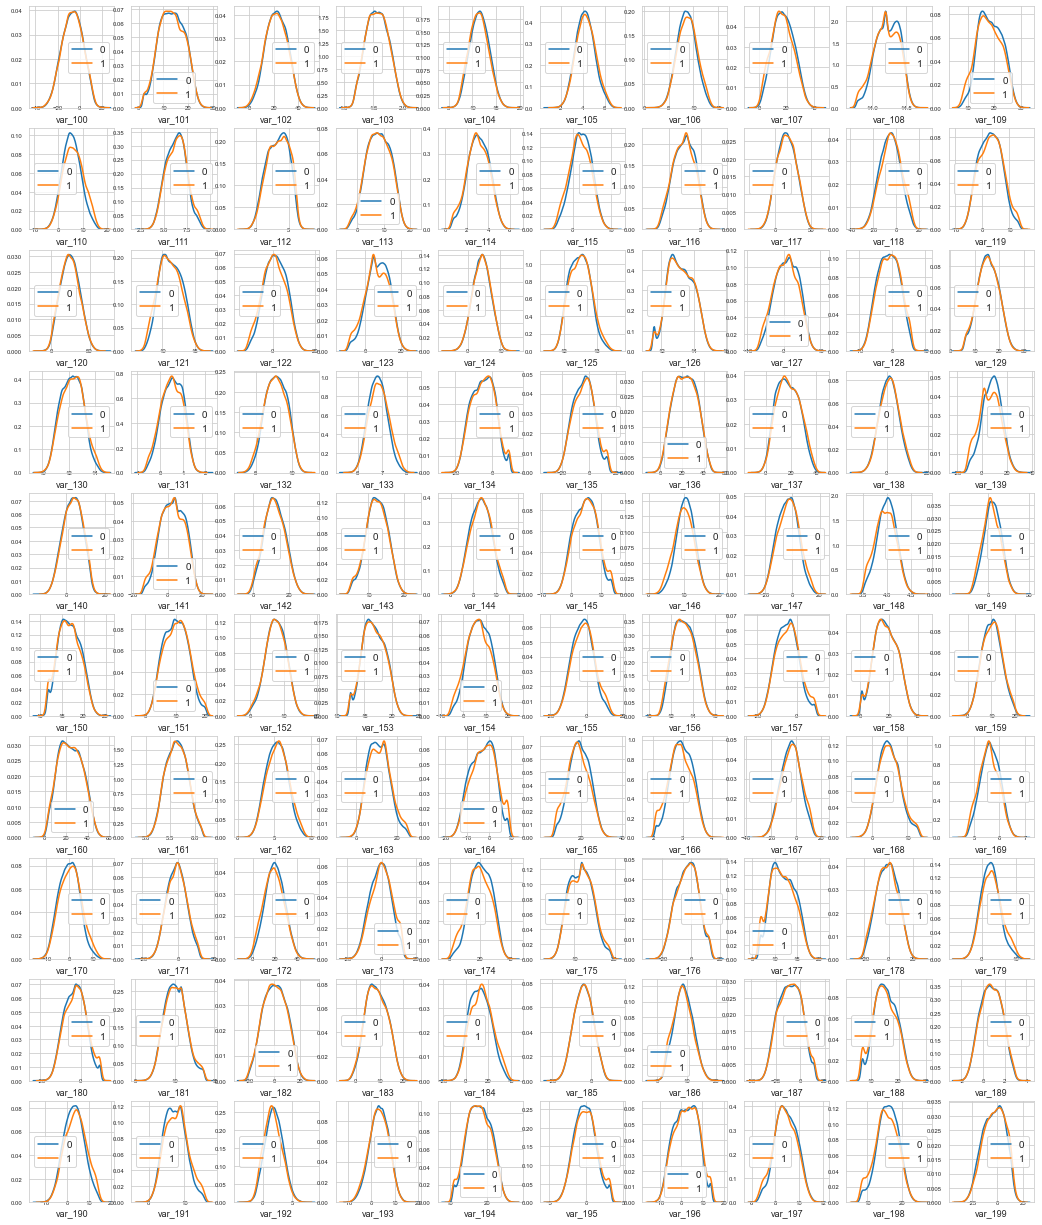

In [24]:
features = train_df.columns.values[102:202]
plot_feature_distribution(t0, t1, '0', '1', features)

## train vs test 
* 트레인셋과 테스트셋도 분포가 다른 피쳐가 있는지 살펴보자
* 만약, 있다면, 편향된 split이어서, 트레인 모델이 테스트셋에 동작 안할 수 있다

<Figure size 432x288 with 0 Axes>

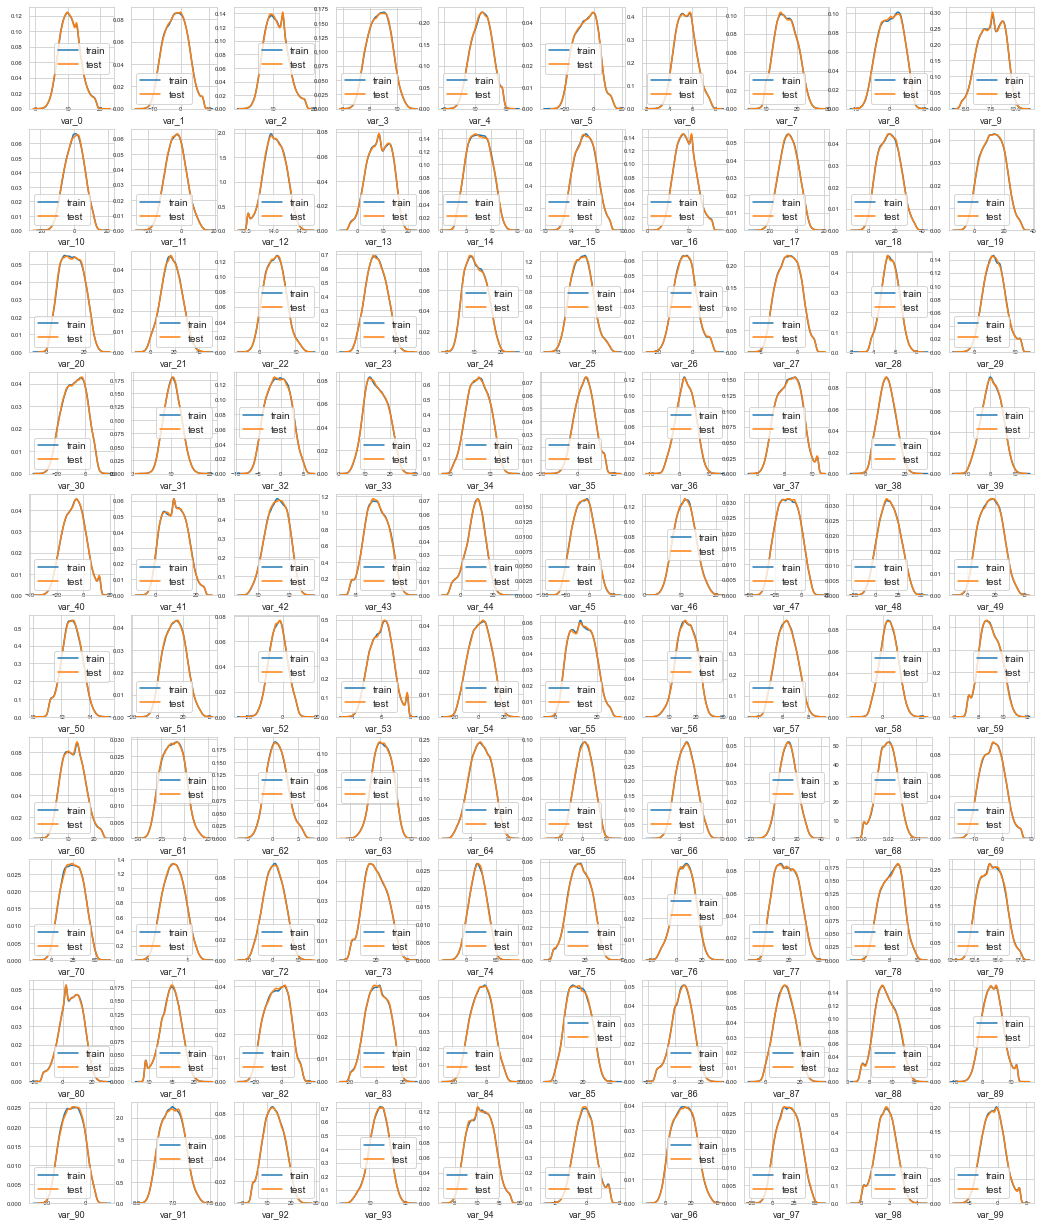

In [25]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

<Figure size 432x288 with 0 Axes>

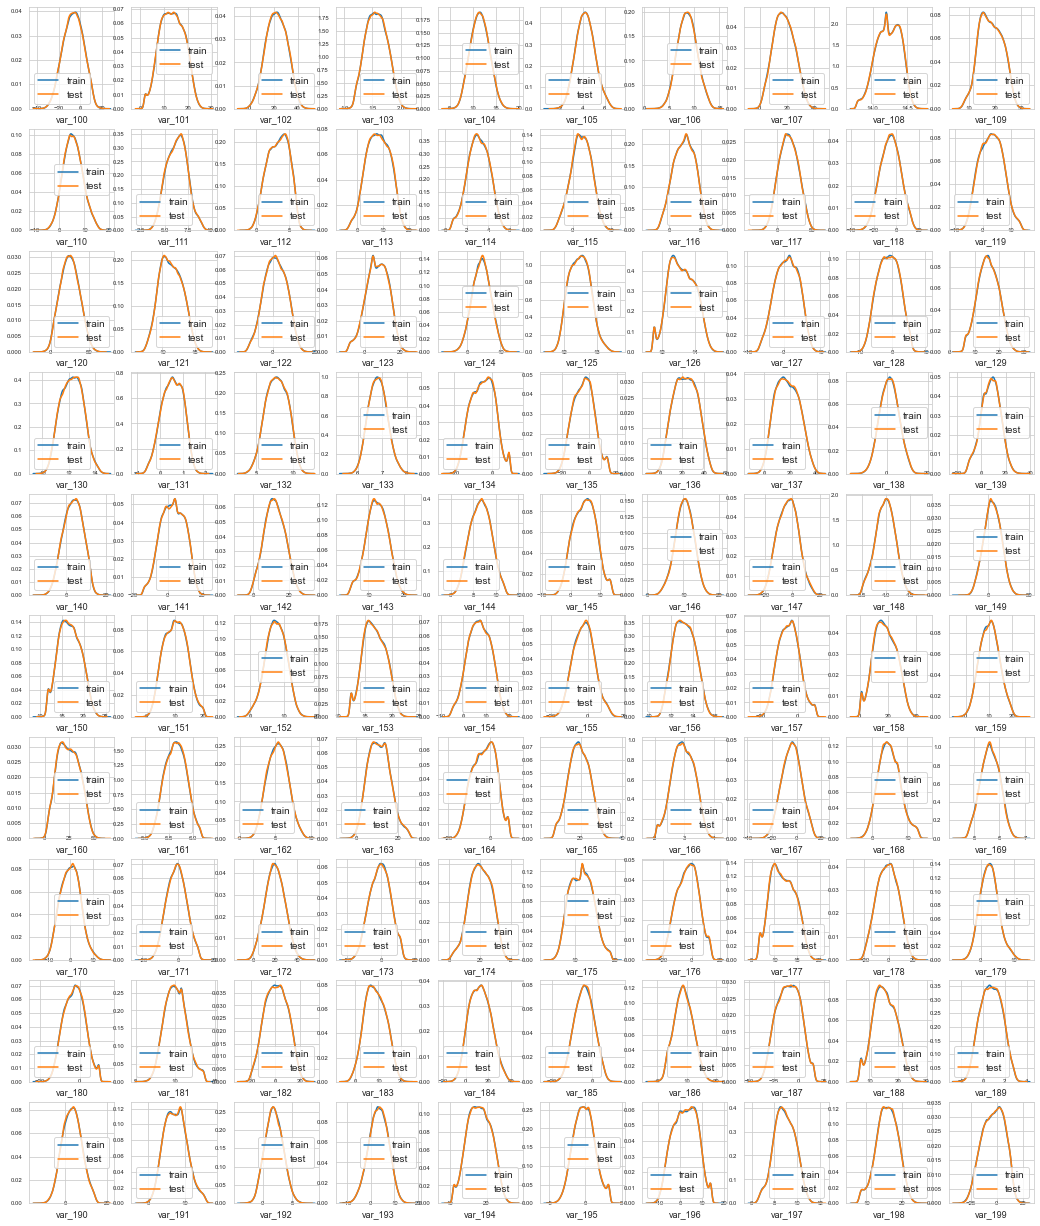

In [26]:
features = train_df.columns.values[102:202]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

# 피쳐를 좀 더 면밀히 살펴보자
* 피쳐값들의 분포가 skew 되었는지, 너무 쫑긋한지 (Kurtosis)

## sum (or mean)

### 하나의 row의 모든 피쳐값들을 다 더해보면, 
* 즉, 개인별 피쳐 총합을 plot (어떤 개인은 값이 1,700 정도로 높고, 어떤 개인은 값이 1,000 정도 나오고..)

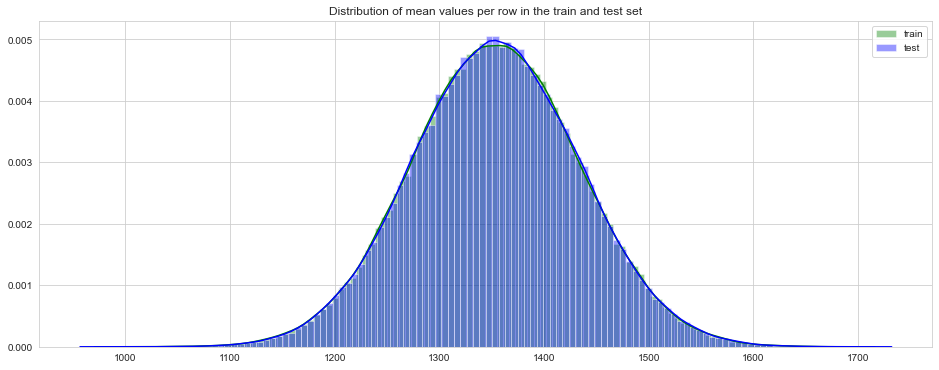

In [29]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].sum(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].sum(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

### 모든 row에 대해서, 각 피쳐값들의 평균을 내서 보면,
* 피쳐별로 어떤 피쳐는 대부분 -10 근처에 있고, 어떤 피쳐는 대부분 20 근처에 있듯이,
* 피쳐별로 값의 range가 많이 다르네..

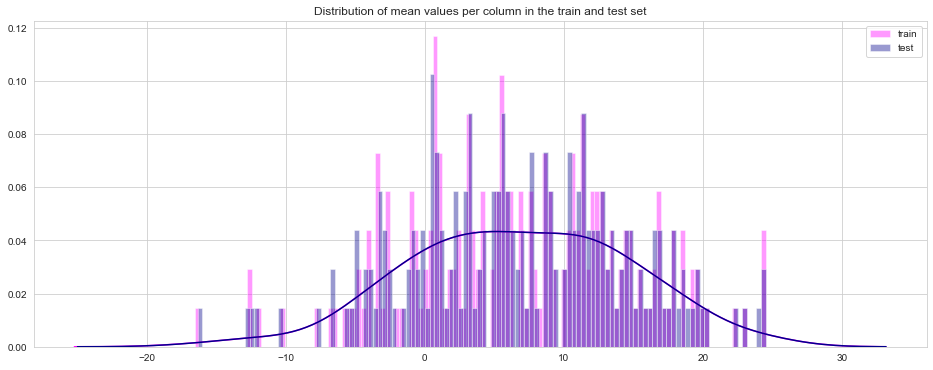

In [35]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

## std

### 각 row 별로
* 각 row에 대해, std를 구해보면, 어떤 고객은 8 정도로 피쳐별 변동이 적고, 어떤 고객은 12 정도로 피쳐별 변동이 크다
* std가 높은 고객은, 사용성에 대해, 호불호있게 썼다는 이야기인듯.

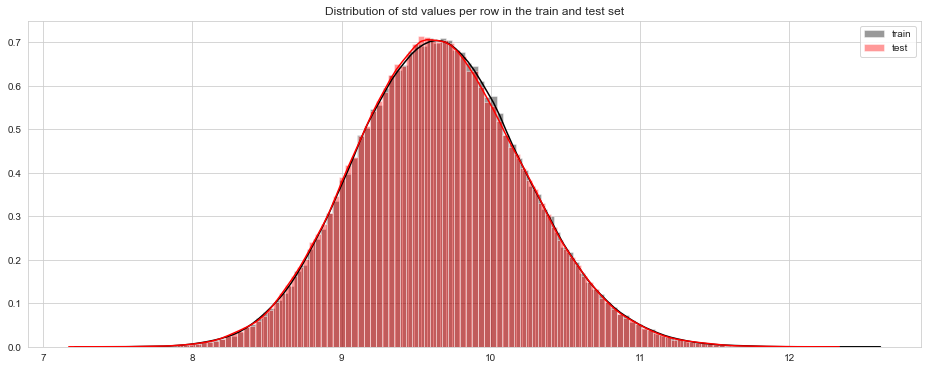

In [30]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

 ### 그럼 컬럼별로는?

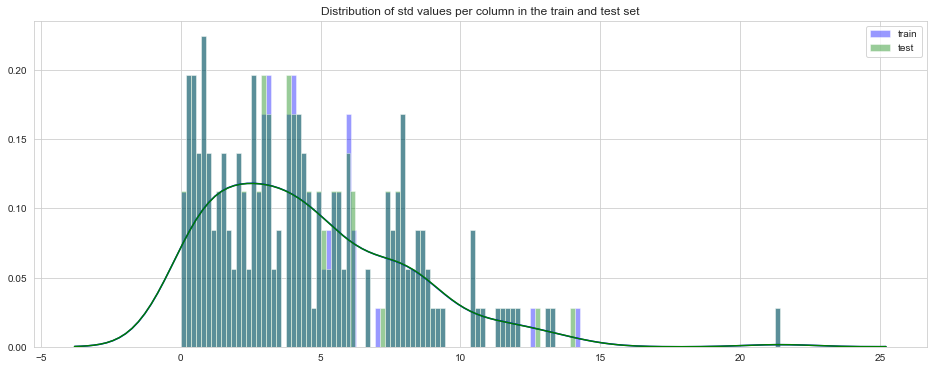

In [31]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

## target=0 vs target=1

### row 별로
* 분포가 다르면 좋은 피쳐로 쓰일 수 있음
* 각 row 별 계산

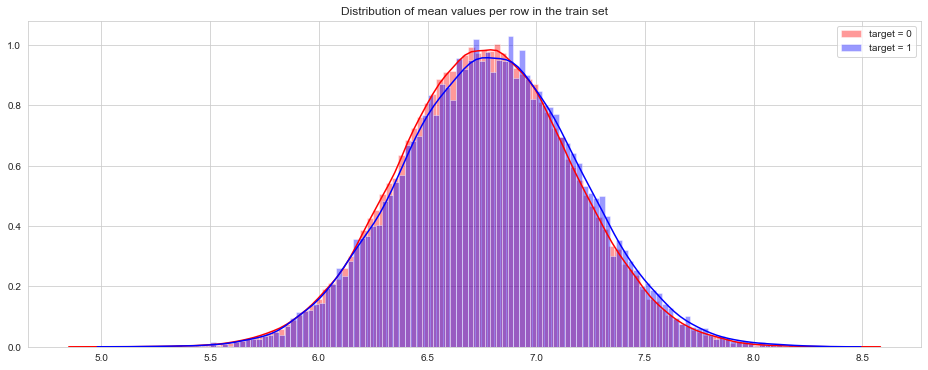

In [32]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train set")
sns.distplot(t0[features].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### 피쳐별로는?
* 해석을 어떻게 해야 하냐면?
* 어떤 피쳐가 변별력을 가지느냐로 해석 가능

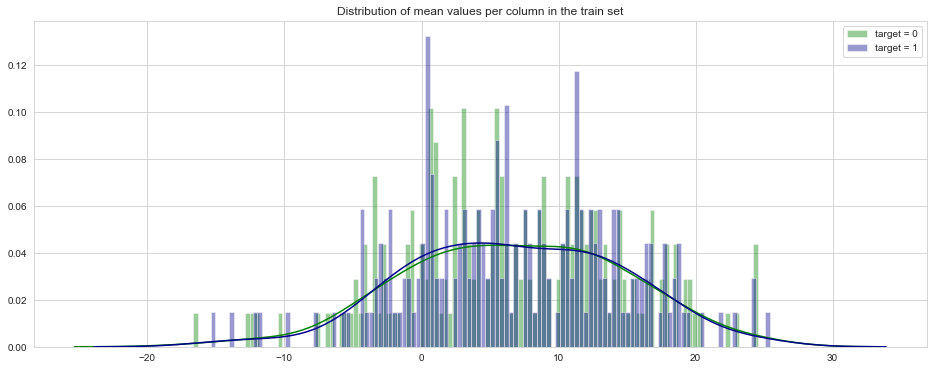

In [33]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train set")
sns.distplot(t0[features].mean(axis=0),color="green", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## Min

### row 별로 (개인별로)

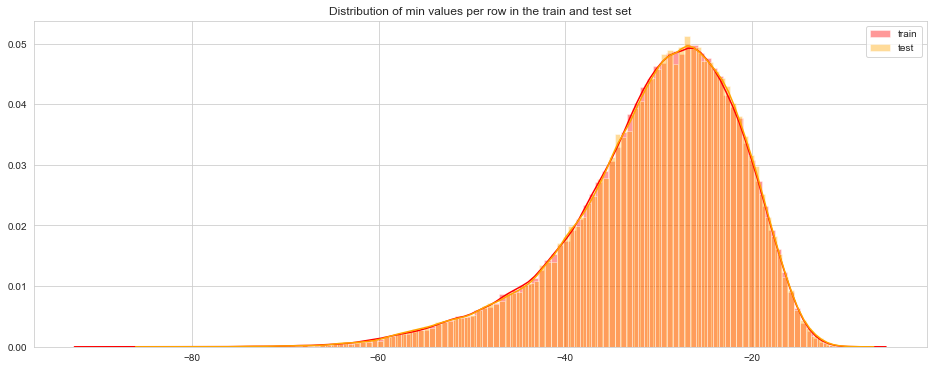

In [36]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per row in the train and test set")
sns.distplot(train_df[features].min(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

### 컬럼별로 (즉, 피쳐별로)

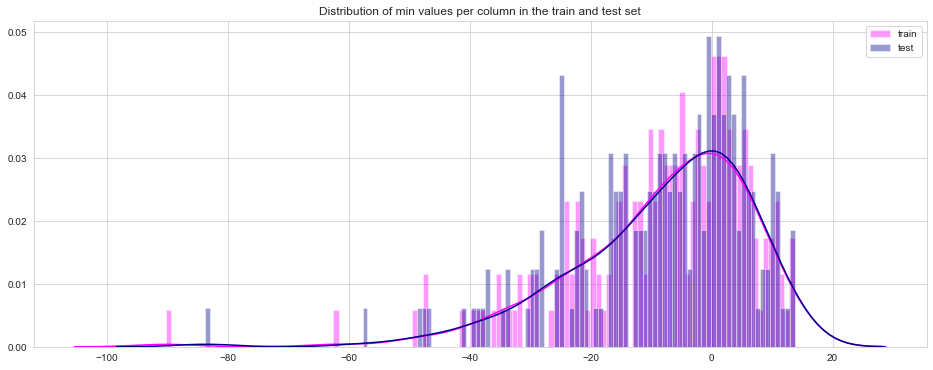

In [37]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of min values per column in the train and test set")
sns.distplot(train_df[features].min(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].min(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

## Max

### row 별로

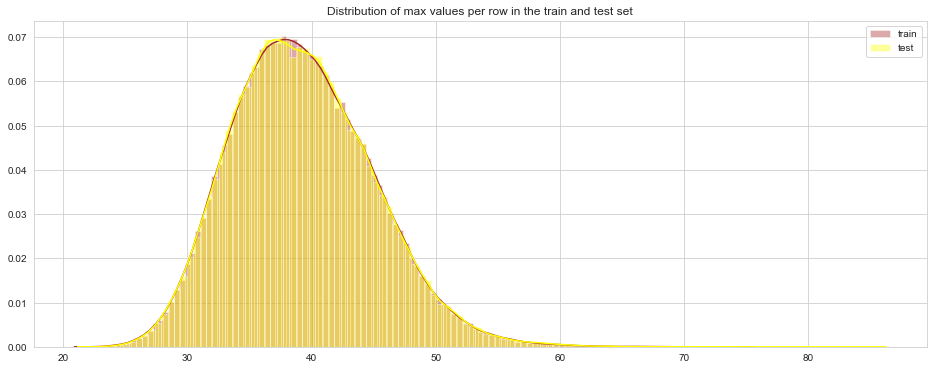

In [38]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per row in the train and test set")
sns.distplot(train_df[features].max(axis=1),color="brown", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

### 컬럼별로

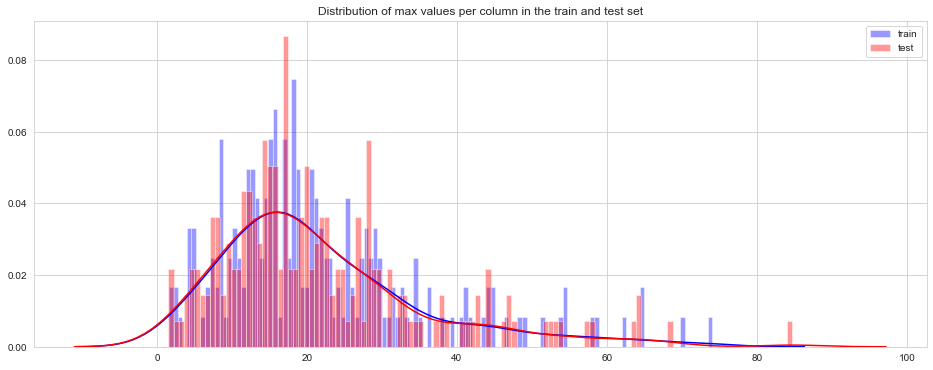

In [39]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of max values per column in the train and test set")
sns.distplot(train_df[features].max(axis=0),color="blue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].max(axis=0),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

## Target=0 vs 1 regarding Min

### row 별로

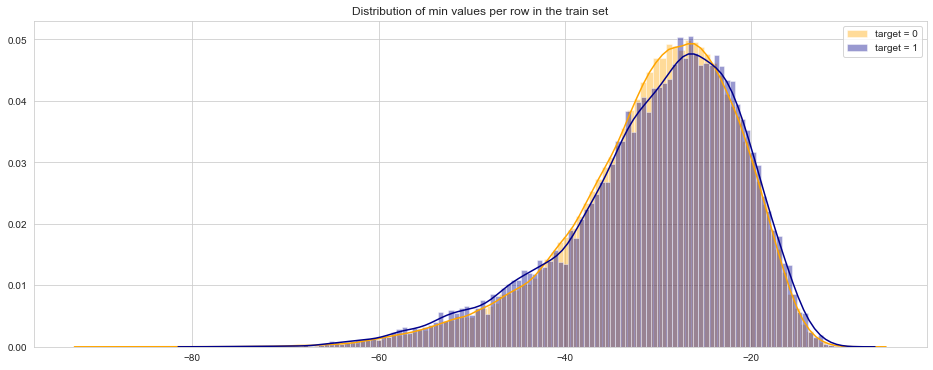

In [40]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### 컬럼별로

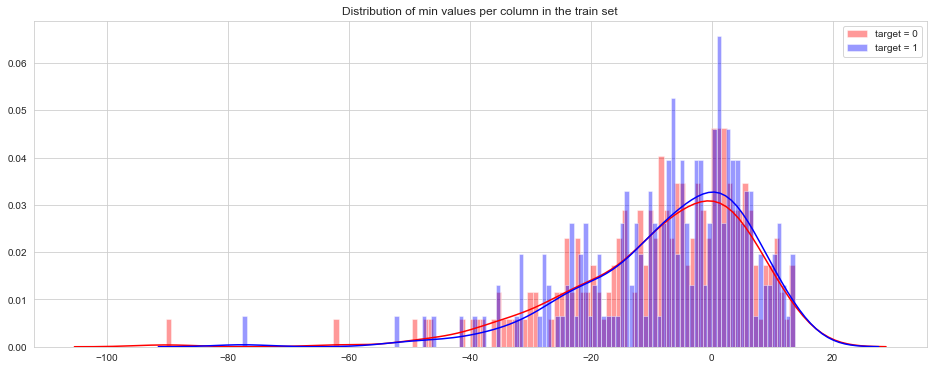

In [41]:
plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## target=0 vs 1 regarding Max

### row별로

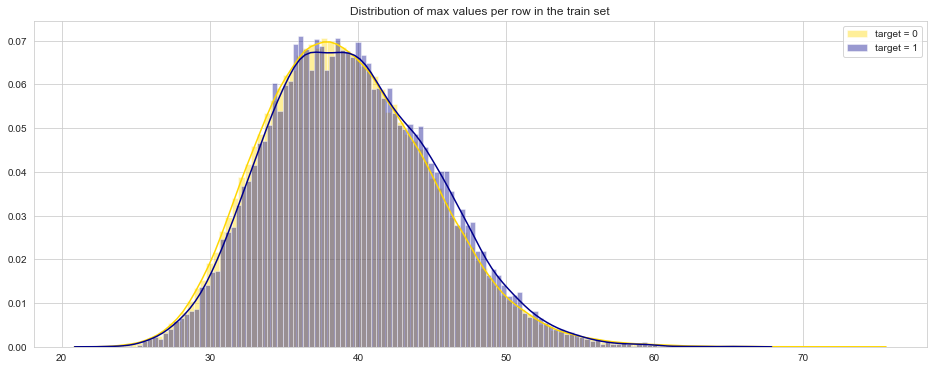

In [42]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### 컬럼별로

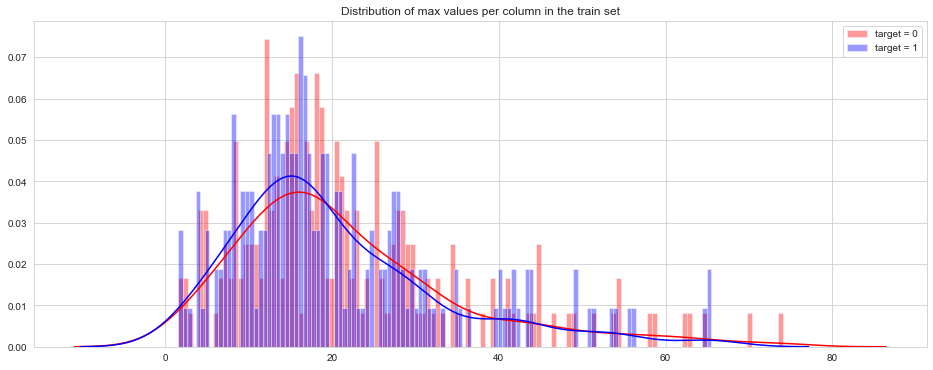

In [43]:
plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## Distribution of skew and kurtosis

### row 별로

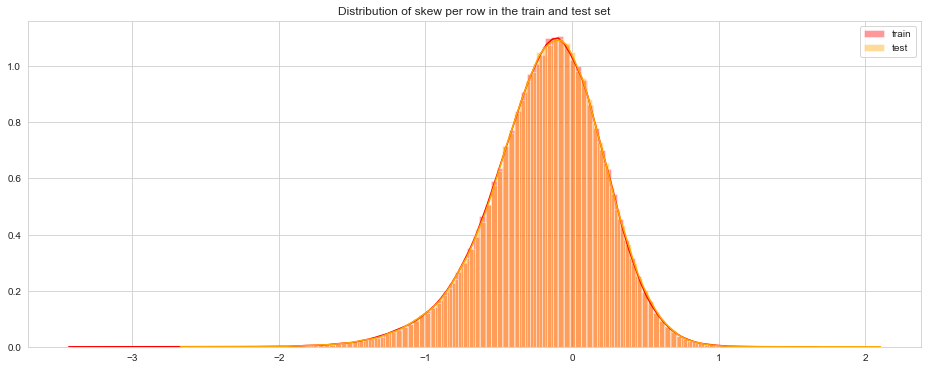

In [44]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

### 컬럼별로

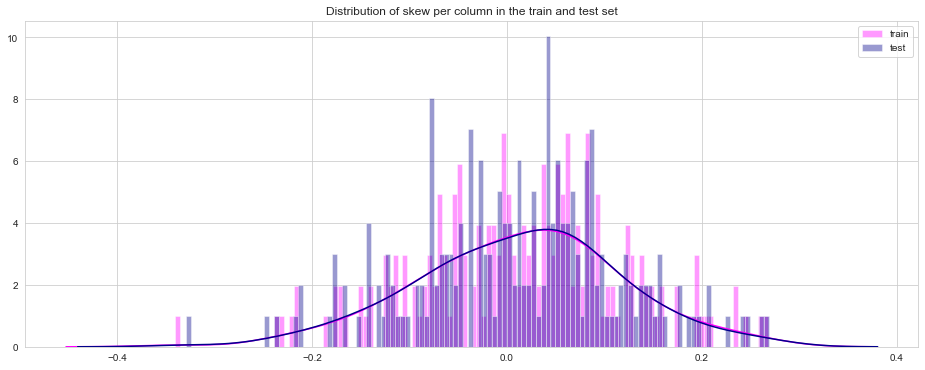

In [45]:
plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

## kurtosis

### row 별로

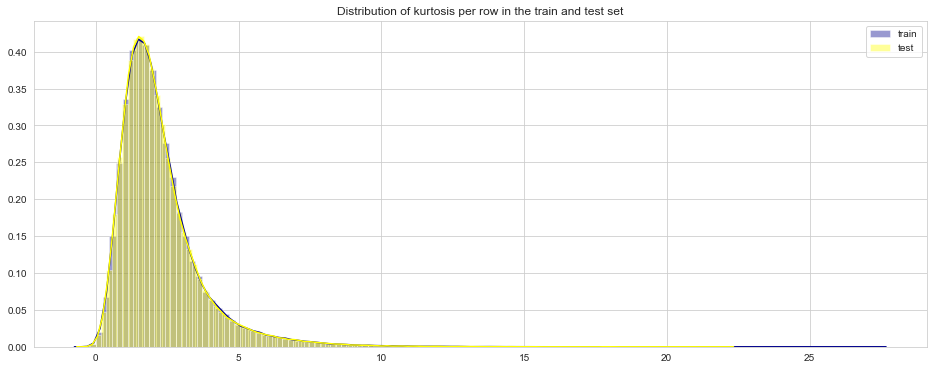

In [46]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

### 컬럼별로

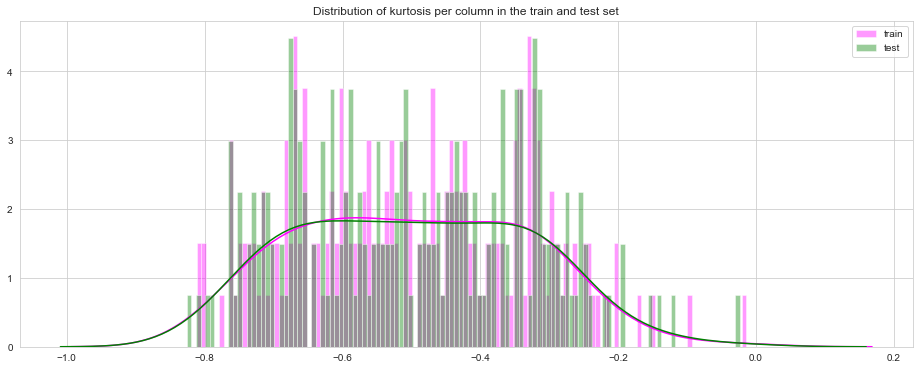

In [47]:
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()

## 타겟 0 vs 1 - skew

### row 별로

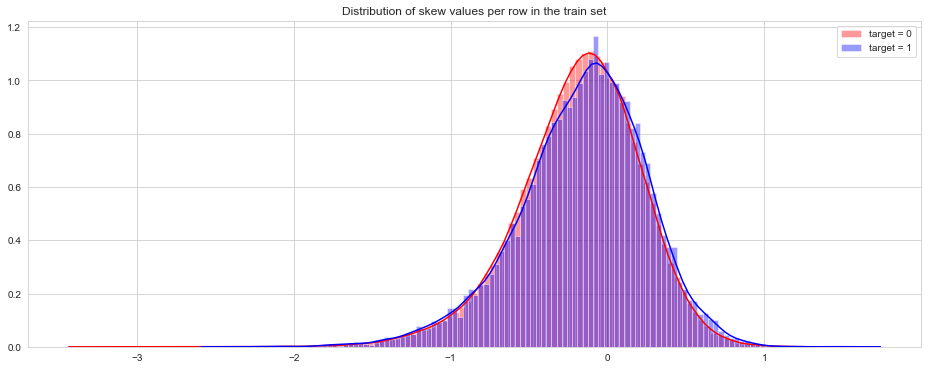

In [48]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per row in the train set")
sns.distplot(t0[features].skew(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### 컬럼별로 

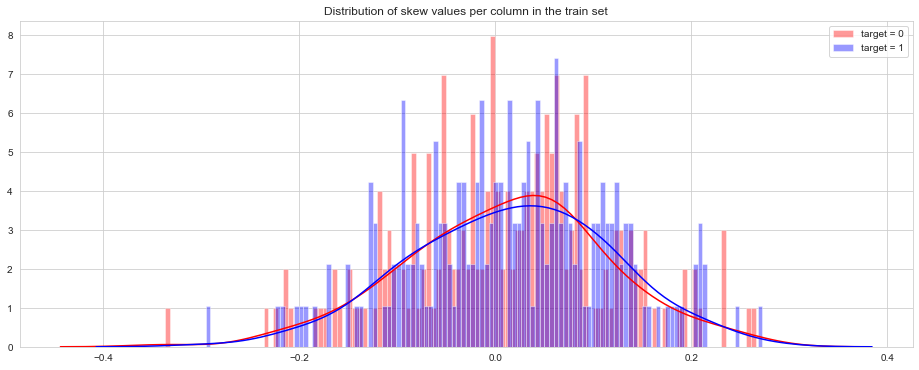

In [49]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of skew values per column in the train set")
sns.distplot(t0[features].skew(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].skew(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## 타겟 0 vs 1 - kurtosis

### row 별로

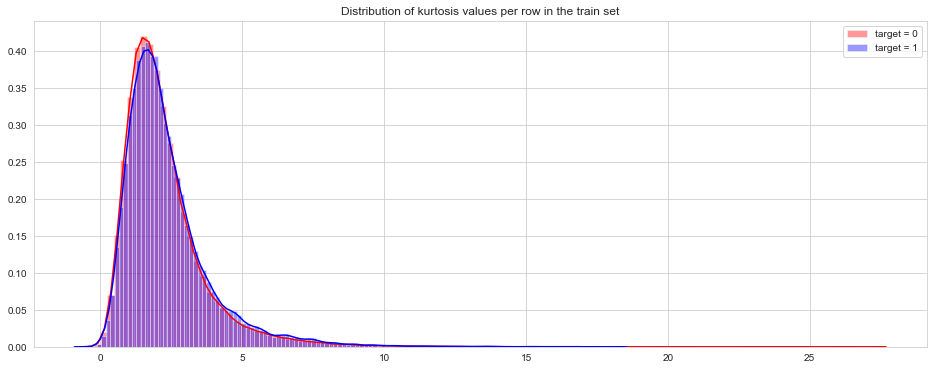

In [50]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per row in the train set")
sns.distplot(t0[features].kurtosis(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

### 컬럼별로

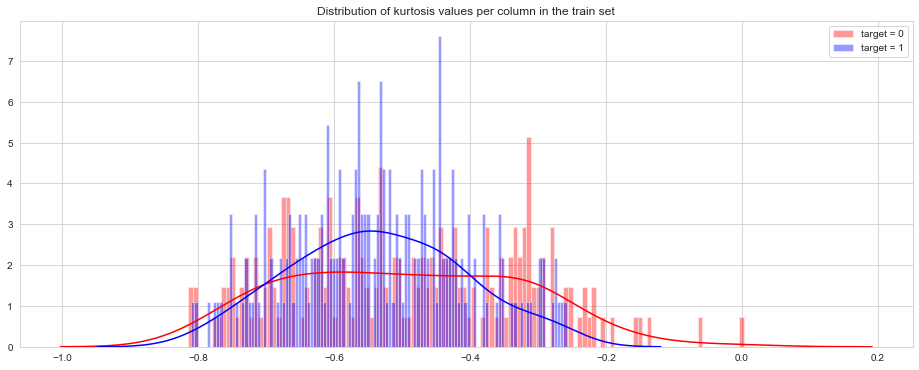

In [51]:
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis values per column in the train set")
sns.distplot(t0[features].kurtosis(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].kurtosis(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

## Features correlation¶
* 피쳐간의 관계를 알아보자
* 피쳐간의 상관관계가 정말 별로 없다. 
* 이유는, 가장 높은 상관관계도 0.0097 정도인데....

In [54]:
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

In [57]:
# 상관관계 낮은 것들
correlations.head(5)

level_0  level_1             0
0   var_75  var_191  2.703975e-08
1  var_191   var_75  2.703975e-08
2  var_173    var_6  5.942735e-08
3    var_6  var_173  5.942735e-08
4  var_126  var_109  1.313947e-07

In [58]:
# 상관관계 높은 것들
correlations.tail(5)

level_0  level_1         0
39795  var_165   var_81  0.009714
39796   var_53  var_148  0.009788
39797  var_148   var_53  0.009788
39798   var_26  var_139  0.009844
39799  var_139   var_26  0.009844

# 피쳐별로 중복값이 얼마나 있는지 알아보자

In [59]:
features = train_df.columns.values[2:202]
unique_max_train = []
unique_max_test = []
for feature in features:
    values = train_df[feature].value_counts()
    unique_max_train.append([feature, values.max(), values.idxmax()])
    values = test_df[feature].value_counts()
    unique_max_test.append([feature, values.max(), values.idxmax()])

## train 셋에 대해서

In [60]:
np.transpose((pd.DataFrame(unique_max_train, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

68       108      126      12      91       103      148  \
Feature         var_68  var_108  var_126   var_12  var_91  var_103  var_148   
Max duplicates    1084      313      305      203      66       61       59   
Value           5.0214  14.1999  11.5356  13.5545  6.9537   1.6662   4.0456   

                   71       161      25       125      169      166      133  \
Feature         var_71  var_161   var_25  var_125  var_169  var_166  var_133   
Max duplicates      54       52       41       40       39       39       39   
Value           0.7031   5.7688  13.6723  12.5159   5.6941   2.7306   6.8876   

                    43   
Feature          var_43  
Max duplicates       39  
Value           11.4522

## test 셋에 대해서
* train/test 셋 모두 중복값이 많은 필드들의 추세는 매우 유사

In [61]:
np.transpose((pd.DataFrame(unique_max_test, columns=['Feature', 'Max duplicates', 'Value'])).\
            sort_values(by = 'Max duplicates', ascending=False).head(15))

68       126      108      12      91       103      148  \
Feature         var_68  var_126  var_108   var_12  var_91  var_103  var_148   
Max duplicates    1104      307      302      188      86       78       74   
Value           5.0197  11.5357  14.1999  13.5546  6.9939   1.4659   4.0004   

                    161      25      71       43       166      125      169  \
Feature         var_161   var_25  var_71   var_43  var_166  var_125  var_169   
Max duplicates       69       60      60       58       53       53       51   
Value            5.7114  13.5965  0.5389  11.5738   2.8446  12.2189   5.8455   

                    133  
Feature         var_133  
Max duplicates       50  
Value            6.6873